In [11]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

RNG = np.random.default_rng(12345)

In [13]:
def loss(actual, pred):
    return 0.5 * np.sum((actual - pred)**2)

def sigma(x):
    return 1 / (1 + np.exp(-x))

def sigma_prime(x):
    return sigma(x) * (1 - sigma(x))

# setup

In [210]:
period = 50.0
ts = np.sort(RNG.integers(-100, 100, size=(1000,)))

# generate features as Fourier series
num_sins = 10
amplitudes = RNG.integers(low=1, high=10, size = (1, num_sins))
x = np.zeros(shape=(num_sins, len(ts)))
for k in range(1,num_sins+1):
    x[k-1] = (-1)**k * np.sin(2 * np.pi * k * ts / period) / k + (RNG.uniform(-0.5, 0.5, size=ts.shape))
x = x.T * amplitudes

# generate sawtooth wave as target
y = 1*2*(ts/period - np.floor(0.5 + ts/period)) + (RNG.uniform(-0.05, 0.05, size=ts.shape))

oos_ts = np.sort(RNG.integers(100, 150, size=(len(ts)//50,)))
x_test = np.zeros(shape=(num_sins, len(oos_ts)))
for k in range(1,num_sins+1):
    x_test[k-1] = (-1)**k * np.sin(2 * np.pi * k * oos_ts / period) / k + (RNG.uniform(-0.5, 0.5, size=oos_ts.shape))
x_test = x_test.T * amplitudes
y_test = 1*2*(oos_ts/period - np.floor(0.5 + oos_ts/period)) + (RNG.uniform(-0.05, 0.05, size=oos_ts.shape))

# OLS

In [15]:
def ols_fit(x, y, const=True):
    if const: x = np.concat((np.ones((x.shape[0], 1)), x), axis = 1)

    betas = np.linalg.inv(x.T @ x) @ x.T @ y

    if const:
        return betas[0], betas[1:], x @ betas
    else:
        return betas, x @ betas

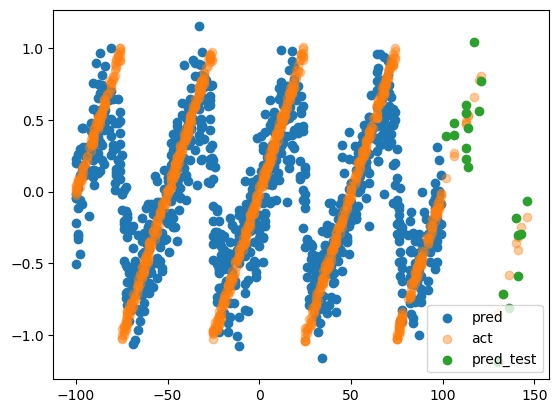


    mse  =  56.7234
    mape =  116.7384%



In [229]:
b0, betas, in_sample_preds = ols_fit(x, y)
out_sample_preds = b0 + x_test @ betas

plt.scatter(ts, in_sample_preds, label = 'pred')
plt.scatter(np.append(ts, oos_ts), np.append(y, y_test), label = 'act', alpha = 0.4)
plt.scatter(oos_ts, out_sample_preds, label = 'pred_test')
plt.legend()
plt.show()

print(f'''
    mse  = {loss(y, in_sample_preds): 0.4f}
    mape = {100*np.mean(np.abs(in_sample_preds/y - 1)): 0.4f}%
''')

# neural network hardcoded

In [40]:
layer_neurons = {
    0: 10,
    1: 16,
    2: 16,
    3: 1
}

In [198]:
weights1 = RNG.uniform(low = -1, high = 1, size = (layer_neurons[1],layer_neurons[0]))
weights2 = RNG.uniform(low = -1, high = 1, size = (layer_neurons[2],layer_neurons[1]))
weights3 = RNG.uniform(low = -1, high = 1, size = (layer_neurons[3],layer_neurons[2]))
epoch = 0

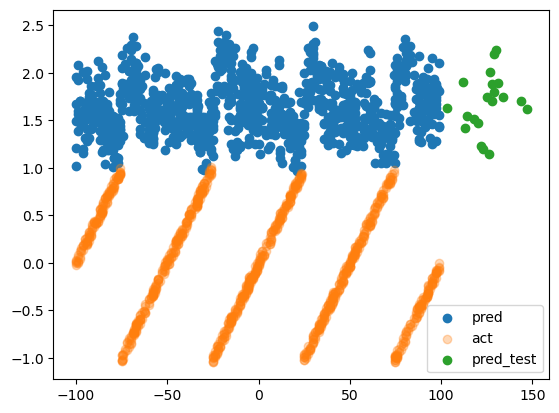

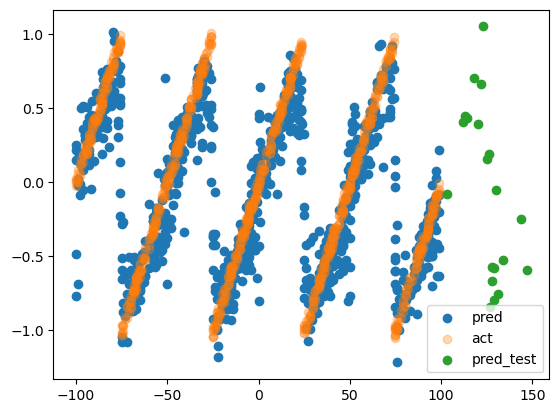

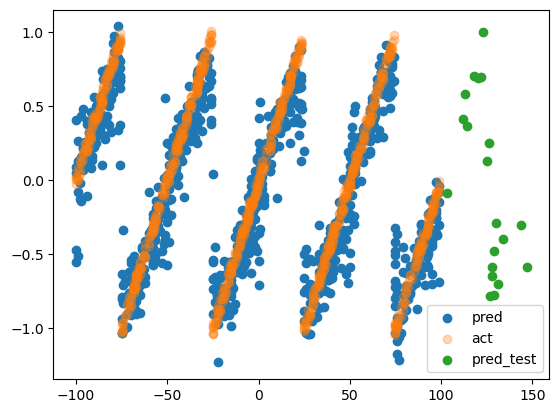

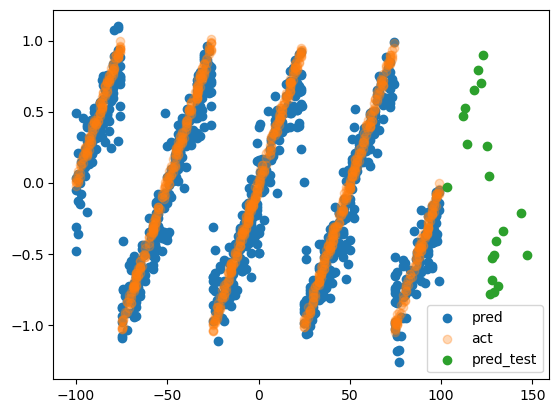

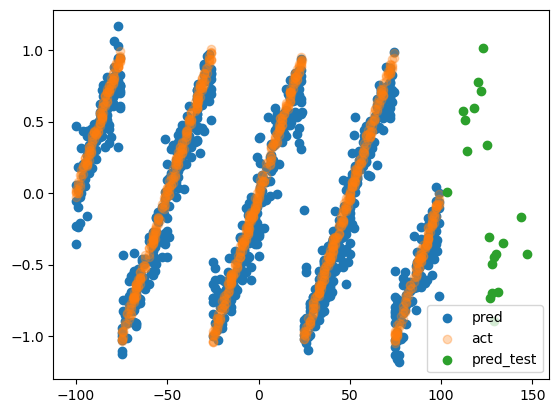

KeyboardInterrupt: 

In [199]:
while epoch < 5*10**4 + 1:
    # forward pass

    # apply layer1
    # intermediate value z
    z1 = weights1 @ x.T
    a1 = sigma(z1)

    # apply layer2
    z2 = weights2 @ a1
    a2 = sigma(z2)

    # apply layer3
    z3 = weights3 @ a2
    a3 = z3

    if epoch % 10**4 == 0:
        oos_a3 = weights3 @ sigma(weights2 @ sigma(weights1 @ x_test.T))

        plt.scatter(ts, a3, label='pred')
        plt.scatter(ts, y, label='act', alpha = 0.3)
        plt.scatter(oos_ts, oos_a3, label='pred_test')
        plt.legend()
        plt.show()

    # backpropagation

    # calculate gradient
    d3 = (a3 - y)
    grad_weights3 = d3 @ (a2.T / a2.shape[1])

    d2 = a2*(1-a2) * (weights3.T @ d3)
    grad_weights2 = d2 @ (a1.T / a2.shape[1])

    d1 = a1*(1-a1) * (weights2.T @ d2)
    grad_weights1 = d1 @ (x / x.shape[0])

    weights1 -= 0.4*grad_weights1
    weights2 -= 0.4*grad_weights2
    weights3 -= 0.4*grad_weights3

    epoch += 1

print(f'''
    mse  = {loss(y, a3)}
    mape = {np.mean(np.abs(a3/y - 1))}
''')

# neural network class

In [225]:
class NeuralNetworkRegression:

    def __init__(
        self,
        x,
        y,
        hidden_layers = None,
        num_hidden_layers = None,
        seed = random.randint(1, 10**5),
        learning_rate = None,
        minibatch_size = None,
        max_epochs = 5*10**4
    ):
        '''
        This class defines a Neural Network Regression object. It takes in a N x P array of inputs 
        (N samples, P features) and predicts an N x 1 array of targets. 
        Weights are trained by backpropagation on a least-squares loss function (no biases in this simple model).
        The activation function is only sigmoid.

        Input Parameters:
            x: N x P input array of N samples with P features. Numpy array should have shape (N, P)
            y: N x 1 output array of N samples. Numpy array should have shape (N, 1)
            
            Optional Parameters:
            hidden_layers = None: dictionary with layer indices as keys and number of neurons in that layer as values
                hidden_layers must index from 1 to L-1 (all inclusive)
                
                these two layers get imputed by the input X and Y:
                input layer 0 must map to P (x.shape[1])
                output layer L must map to 1 (y.shape[1])

                hidden layers 1 through L-1 can have any number of neurons
            
            num_hidden_layers = None: integer giving how many 16-neuron hidden layers to add 
                (which only applies if layers = None)
            
            seed = random integer: you can choose the random number generation seed (for replicability)
                (if unchosen, will generate a random integer for you)

            learning_rate = float: learning rate of stochastic gradient descent (i.e., step size in gradient direction)
                (if unchosen, will be linear decay starting from 0.5 and going down to 0.0001 using linear decay)

            minibatch_size = int: how large the minibatches should be in stochastic gradient descent
                (if unchosen, will be N/10, where N is the number of samples)

            max_epochs = 5*10**4: how many training epochs should be performed at maximum
        '''

        layers = { 0: x.shape[1], }

        if hidden_layers is None:
            if num_hidden_layers is not None:
                for i in range(num_hidden_layers):
                    layers[i+1] = 16
            else:
                num_hidden_layers = 0
        else:
            for layer in hidden_layers:
                if layer == 0:
                    raise ValueError('hidden_layers cannot have 0 as a layer index. the 0th layer is imputed from the shape of the input X.')
                layers[layer] = hidden_layers[layer]
                num_hidden_layers = len(hidden_layers)
        
        layers[num_hidden_layers + 1] = 1

        
        S = sum(layers.keys())
        L = max(layers.keys())

        if not S == (L*(L+1))//2:
            raise ValueError(f'''
                hidden_layers must contains all indices from 1 to L-1, where 0 is the input layer index 
                and L is the maximum of the indices. Based on your input, you wanted {num_hidden_layers} hidden layers,
                so your indices should have been from 1 to {num_hidden_layers} (inclusive).
            ''')

        # copy input variables            
        self.x = x.T
        self.y = y
        self.layers = layers
        self.seed = seed
        
        # save number of samples
        self.N = x.shape[0]

        if learning_rate is None:
            step_size = (0.5 - 0.0001)/max_epochs
            learning_rate = np.arange(0.0001, 0.5 + step_size/2, step_size)[::-1]

        if minibatch_size is None:
            minibatch_size = self.N//10

        self.learning_rate = learning_rate
        self.minibatch_size = minibatch_size
        self.max_epochs = max_epochs

        # set activation function
        self.sigma = lambda x: 1 / (1 + np.exp(-x))

        # set up random number generator for weights
        self.rng = np.random.default_rng(seed)

        # initialize random starting weights
        self.weights = [
            self.rng.uniform(low = -1, high = 1, size = (layer_neurons[i],layer_neurons[i-1]))
            for i in range(1,L+1)
        ]
        self.epochs_trained = 0

        # set intermediate variable names for use later
        self.z = []
        self.a = []
        self.deltas = []
    
    def reinitialize(self):
        print('resetting neural network...')
        self.weights = [
            self.rng.uniform(low = -1, high = 1, size = (layer_neurons[i],layer_neurons[i-1]))
            for i in range(1,max(self.layers.keys())+1)
        ]
        self.epochs_trained = 0

    def forward_pass(self):
        # calculate intermediate matrices for activation inputs and activations
        self.z = [None]
        self.a = [x.T]

        L = max(self.layers.keys())

        for i in range(1, L):
            self.z.append(self.weights[i-1] @ self.a[i-1])
            self.a.append(self.sigma(self.z[i]))

        self.z.append(self.weights[L-1] @ self.a[L-1])
        self.a.append(self.z[-1])

    def backpropagate(self):
        if len(self.z) == 0 or len(self.a) == 0:
            self.forward_pass()

        mini_batch_index = self.rng.choice(range(self.N), self.minibatch_size, replace=False, shuffle=False)
        learning_rate = self.learning_rate[self.epochs_trained if self.epochs_trained < self.max_epochs else self.max_epochs - 1]

        deltas = [self.a[-1][:, mini_batch_index] - self.y[mini_batch_index]]
        for i in range(max(self.layers.keys()))[::-1]:
            delta = deltas[-1]

            grad = delta @ (self.a[i][:, mini_batch_index].T / self.minibatch_size)

            # calculate next delta (based on old weights)
            deltas.append(self.a[i][:, mini_batch_index]*(1-self.a[i][:, mini_batch_index]) * (self.weights[i].T @ delta))

            # apply gradient to weights
            self.weights[i] -= learning_rate*grad
        
        self.epochs_trained += 1
        self.deltas = deltas[::-1]

    def fit(self, xtest):
        if xtest.shape[1] != self.x.shape[0]:
            raise ValueError(f'xtest must have {self.x.shape[0]} features to match training input')

        ret = xtest.T
        for w in self.weights[:-1]:
            ret = self.sigma(w @ ret)

        ret = self.weights[-1] @ ret

        return ret
    
    def training_mape(self):
        if len(self.z) == 0 or len(self.a) == 0:
            self.forward_pass()

        mse = np.mean((self.a[-1] - self.y)**2)
        mape = np.mean(np.abs(self.a[-1]/self.y - 1))

        print(f"""
            After {self.epochs_trained} epochs of training, the performance on the training dataset is
                mse  = {mse: 0.4f}
                mape = {100*mape: 0.4f}%
        """)

        return self.epochs_trained, mse, mape
    
    def test_mape(self, xtest, ytest):
        vals = self.fit(xtest)
        mse = np.mean((vals - ytest)**2)
        mape = np.mean(np.abs(vals/ytest - 1))

        print(f"""
            After {self.epochs_trained} epochs of training, the performance on the test dataset is
                mse  = {mse: 0.4f}
                mape = {100*mape: 0.4f}%
        """)

        return self.epochs_trained, mse, mape


In [226]:
nnr = NeuralNetworkRegression(x, y, hidden_layers = {1:16, 2:16}, seed = 123)


            After 0 epochs of training, the performance on the training dataset is
                mse  =  1.4898
                mape =  595.2096%
        

            After 0 epochs of training, the performance on the test dataset is
                mse  =  1.7148
                mape =  319.8276%
        


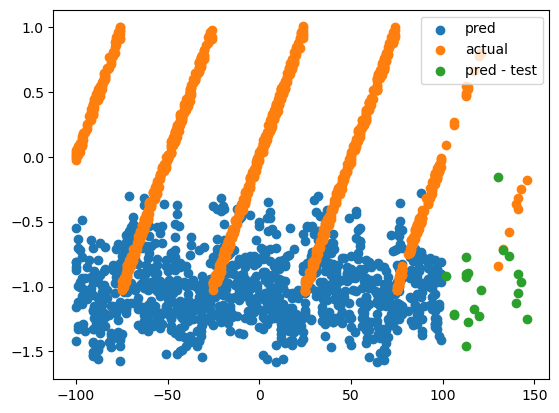


            After 10000 epochs of training, the performance on the training dataset is
                mse  =  0.0588
                mape =  116.2261%
        

            After 10000 epochs of training, the performance on the test dataset is
                mse  =  0.0516
                mape =  52.3361%
        


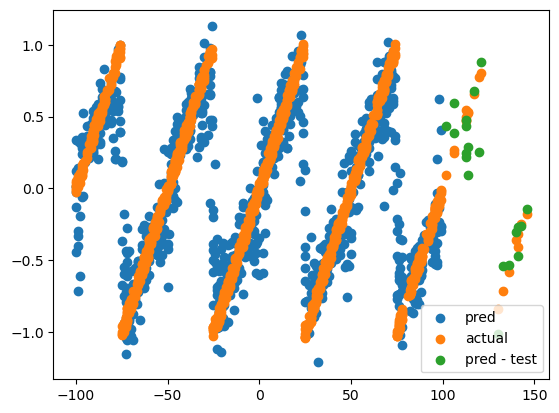


            After 20000 epochs of training, the performance on the training dataset is
                mse  =  0.0436
                mape =  114.7038%
        

            After 20000 epochs of training, the performance on the test dataset is
                mse  =  0.0577
                mape =  50.9741%
        


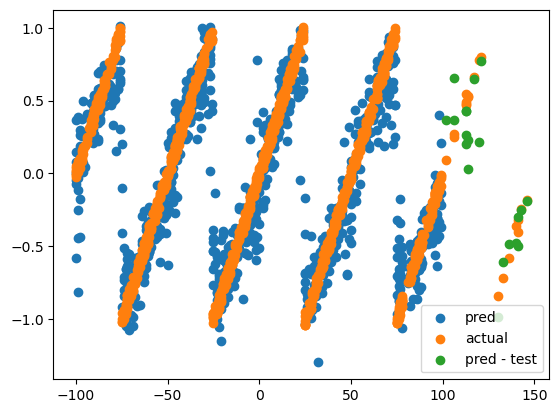


            After 30000 epochs of training, the performance on the training dataset is
                mse  =  0.0365
                mape =  106.2850%
        

            After 30000 epochs of training, the performance on the test dataset is
                mse  =  0.0615
                mape =  53.4927%
        


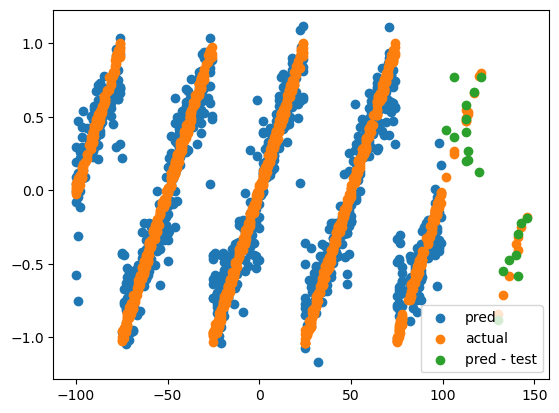


            After 40000 epochs of training, the performance on the training dataset is
                mse  =  0.0331
                mape =  99.2140%
        

            After 40000 epochs of training, the performance on the test dataset is
                mse  =  0.0681
                mape =  54.8756%
        


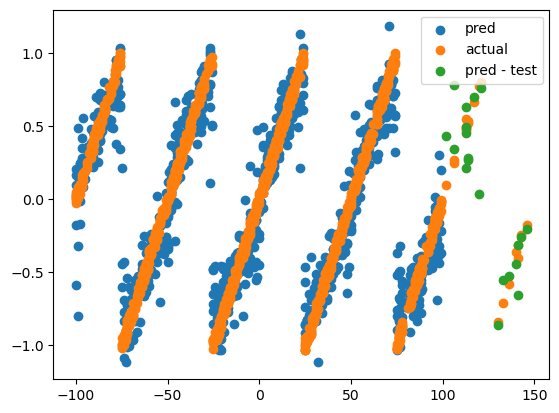

In [228]:
while nnr.epochs_trained < nnr.max_epochs:
    
    if nnr.epochs_trained % 10**4 == 0:
        fitted_vals = nnr.fit(x)
        oos_vals = nnr.fit(x_test)

        nnr.training_mape()
        nnr.test_mape(x_test, y_test)

        plt.scatter(ts, fitted_vals, label = 'pred')
        plt.scatter(np.append(ts, oos_ts), np.append(y, y_test), label = 'actual')
        plt.scatter(oos_ts, oos_vals, label = 'pred - test')
        plt.legend()
        plt.show()

    nnr.forward_pass()
    nnr.backpropagate()